In [1]:
import os
import sys
import time
import numpy as np
from glob import glob

import logging
import warnings

warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

logging.getLogger("tensorflow").setLevel(logging.ERROR) 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import vae_utils as vu
import model_utils as mu

In [5]:
#from skimage.transform import resize

In [6]:
print('tf.version = {}'.format(tf.__version__))
print('tf on GPU = {}'.format(tf.test.is_gpu_available()))

tf.version = 2.12.1
tf on GPU = True


In [7]:
def resblock(X, kernel_size, filter_num, activation):
    Fx = layers.Conv2D(filter_num, kernel_size, padding='same')(X)
    Fx = layers.BatchNormalization()(Fx)
    Fx = layers.Activation(activation)(Fx)
    Fx = layers.Conv2D(filter_num, kernel_size, padding='same')(Fx)
    out = layers.Add()([X, Fx])
    out = layers.BatchNormalization(axis=-1)(out)
    out = layers.Activation(activation)(out)
    return out

In [8]:
filter_nums = [64, 128]
latent_dim = 16
num_embeddings = 128
activation = 'relu'

model_name_save = '/glade/work/ksha/GAN/models/VQ_VAE_P128_{}_{}_L{}_N{}_{}_tune4'.format(filter_nums[0], 
                                                                                            filter_nums[1], 
                                                                                            latent_dim, 
                                                                                            num_embeddings, 
                                                                                            activation)


input_size = (128, 128, 1) #(28, 28, 1) #
latent_size = (32, 32, latent_dim) #(7, 7, latent_dim) #
# 64 144

# encoder
encoder_in = keras.Input(shape=input_size)
X = encoder_in

X = layers.Conv2D(filter_nums[0], 3, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = layers.Conv2D(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[0], activation)
X = resblock(X, 3, filter_nums[0], activation)

X = layers.Conv2D(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[1], activation)
X = resblock(X, 3, filter_nums[1], activation)

encoder_out = layers.Conv2D(latent_dim, 1, padding="same")(X)

model_encoder = keras.Model(encoder_in, encoder_out)

# decoder
decoder_in = keras.Input(shape=latent_size)

X = decoder_in

X = layers.Conv2D(filter_nums[1], 1, padding="same")(X)

X = layers.Conv2DTranspose(filter_nums[1], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[1], activation)
X = resblock(X, 3, filter_nums[1], activation)

X = layers.Conv2DTranspose(filter_nums[0], 3, strides=2, padding="same")(X)
X = layers.BatchNormalization()(X)
X = layers.Activation(activation)(X)

X = resblock(X, 3, filter_nums[0], activation)
X = resblock(X, 3, filter_nums[0], activation)

decoder_out = layers.Conv2D(latent_dim, 1, padding="same")(X)

model_decoder = keras.Model(decoder_in, decoder_out)

# VQ-VAE
IN = keras.Input(shape=input_size)
X = IN
X_encode = model_encoder(X)

vq_layer = vu.VectorQuantizer(num_embeddings, latent_dim)
X_VQ = vq_layer(X_encode)
OUT = model_decoder(X_VQ)
model_vqvae = keras.Model(IN, OUT)



In [9]:
vqvae_trainer = vu.VQVAETrainer(model_vqvae, 1.0, latent_dim, num_embeddings)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5))

In [10]:
W_old = mu.dummy_loader(model_name_save)
vqvae_trainer.vqvae.set_weights(W_old)

In [11]:
#vq_vae.summary()

In [12]:
def precip_norm(x):
    return np.log(x+1)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_MRMS/'

L_valid = 5000

filenames = np.array(sorted(glob(BATCH_dir+'*2020*.npy')))
L = len(filenames)

filename_valid = filenames[::8][:L_valid]
filename_train = list(set(filenames) - set(filename_valid))
L_train = len(filename_train)

Y_valid = np.empty((L_valid, 128, 128, 1))
for i, name in enumerate(filename_valid):
    Y_valid[i, ..., 0] = precip_norm(np.load(name))

In [13]:
L_train

190510

In [14]:
# BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_GFS_MRMS/'
# filename_train = sorted(glob(BATCH_dir+'*.npy'))
# L_train = len(filename_train)

# epochs = 99999
# N_batch = 32
# batch_size = 64

# min_del = 0.0
# max_tol = 3 # early stopping with 2-epoch patience
# tol = 0

# Y_batch = np.empty((batch_size, 128, 128, 1))
# Y_batch[...] = np.nan

# for i in range(epochs):
    
#     print('epoch = {}'.format(i))
#     if i == 0:
#         model_ = vqvae_trainer.vqvae
#         Y_pred = model_.predict(Y_valid)
#         record = mean_absolute_error(Y_valid, Y_pred)
#         print('Initial validation loss: {}'.format(record))
    
#     start_time = time.time()
#     for j in range(N_batch):
        
#         inds_rnd = du.shuffle_ind(L_train)
#         inds_ = inds_rnd[:batch_size]

#         for k, ind in enumerate(inds_):
#             # import batch data
#             name = filename_train[ind]
#             temp_data = np.load(name)
#             Y_batch[k, ..., 0] = temp_data[0, ..., 0]
            
#         vqvae_trainer.fit(Y_batch, epochs=2, batch_size=16, verbose=0)
        
#     # on epoch-end
#     model_ = vqvae_trainer.vqvae
#     Y_pred = model_.predict(Y_valid)
#     record_temp = mean_absolute_error(Y_valid, Y_pred)

#     if record - record_temp > min_del:
#         print('Validation loss improved from {} to {}'.format(record, record_temp))
#         record = record_temp
#         model_ = vqvae_trainer.vqvae
#         model_.save(model_name_save)
        
#     else:
#         print('Validation loss {} NOT improved'.format(record_temp))

#     print("--- %s seconds ---" % (time.time() - start_time))
#     # mannual callbacks

In [15]:
# model_ = vqvae_trainer.vqvae
# model_.save(model_name_save)

In [16]:
# 0.018

In [17]:
# 0.014254429761548011

In [18]:
model_ = vqvae_trainer.vqvae
Y_pred = model_.predict(Y_valid)

157/157 [==============================] - 6s 34ms/step


In [19]:
mean_absolute_error(Y_valid, Y_pred)

0.011616184321313196

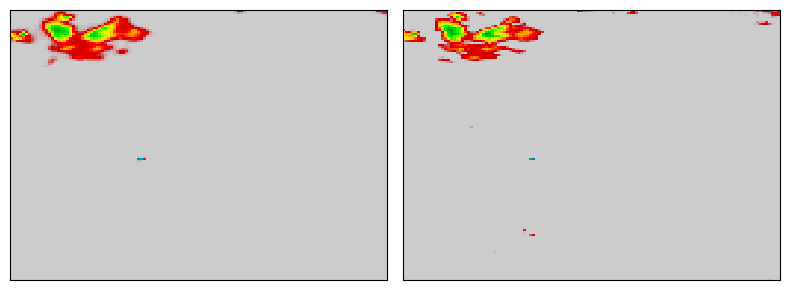

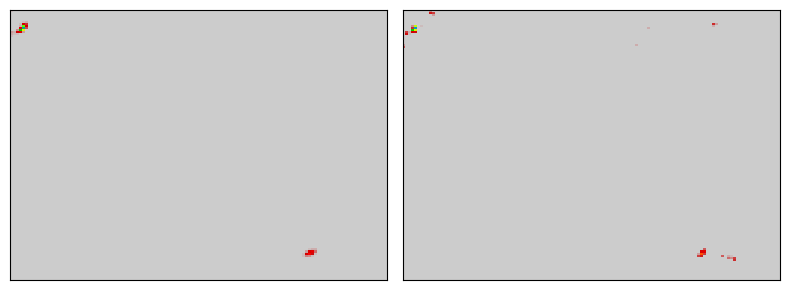

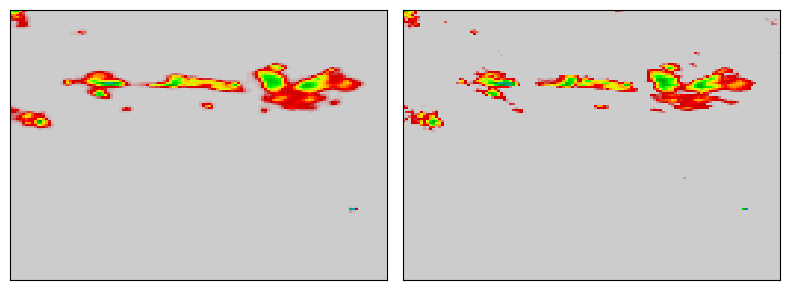

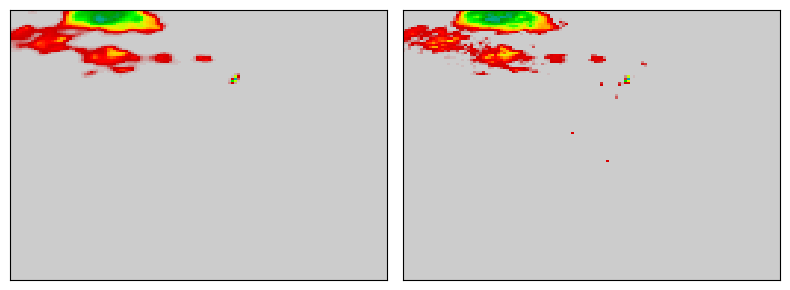

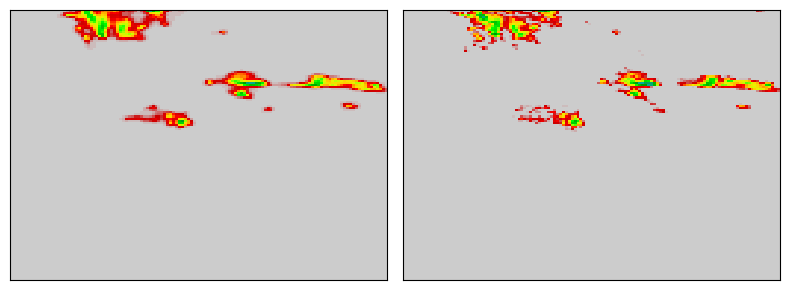

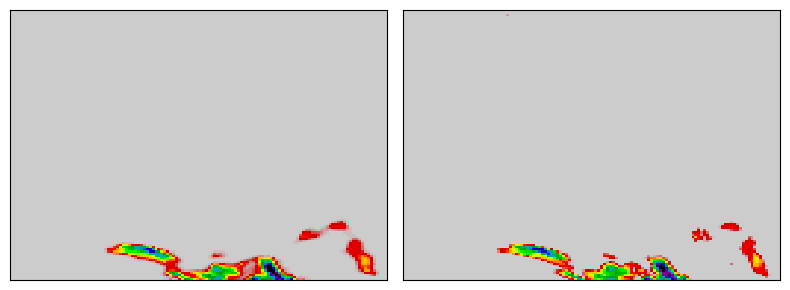

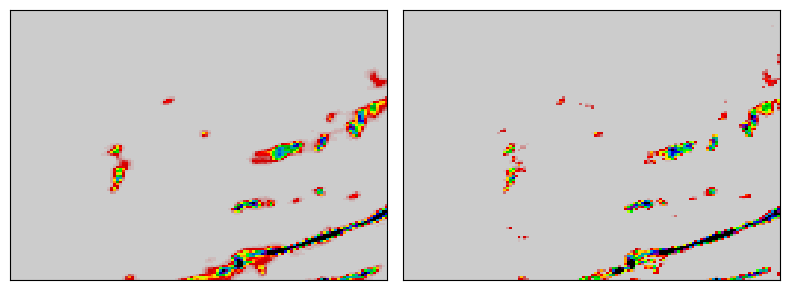

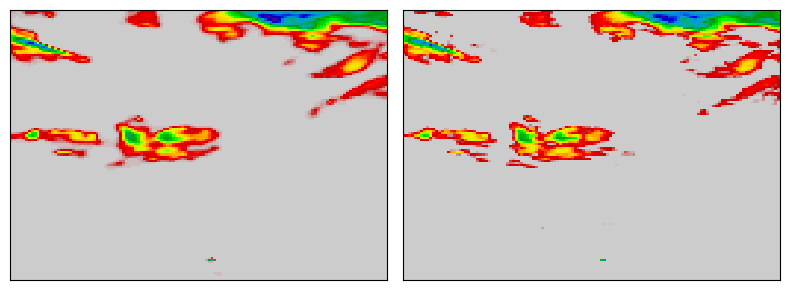

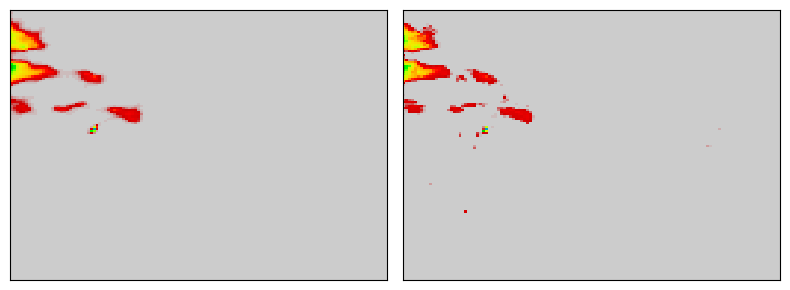

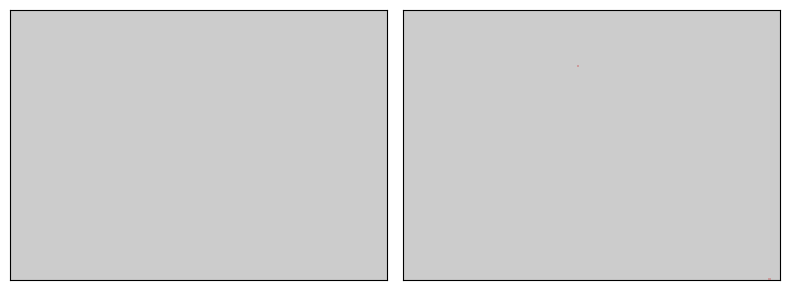

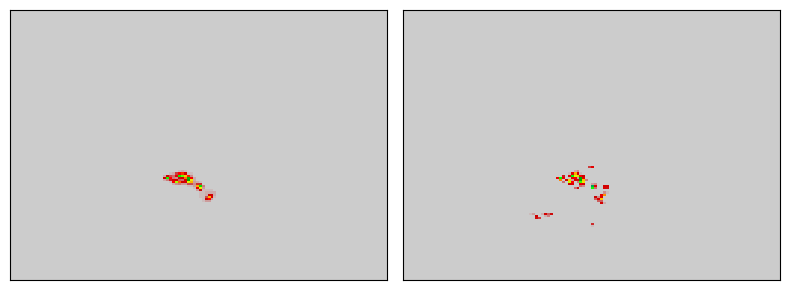

In [21]:
for i in range(10,21,1):

    fig, AX = plt.subplots(1, 2, figsize=(8, 3))
    
    for ax in AX:
        ax.tick_params(axis="both", which="both", bottom=False, 
                       top=False, labelbottom=False, left=False,
                       right=False, labelleft=False)
    plt.tight_layout()
    
    AX[0].pcolormesh(Y_pred[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)
    AX[1].pcolormesh(Y_valid[i, ..., 0], vmin=0, vmax=3, cmap=plt.cm.nipy_spectral_r)